In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

import dateutil
from math import radians
from IPython.display import Video

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import os
import warnings
from tqdm import tqdm
import gc
warnings.filterwarnings('ignore')

In [2]:
%%time
plays = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
players = pd.read_csv('nfl-big-data-bowl/players.csv')
weekMod = pd.read_csv('weekModpos.csv')

In [3]:
weekMod

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,oppO,mateMinDist,closestMate(nflId),mateX,mateY,mateO,diffDir,oppMateDistRatio,orientDiff,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,orientMean,orientVar,oppOrientMean,oppOrientVar
0,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,before_snap,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1.916899,2533040.0,193.97,90.78,36.15,257.61,5.867759,2552315.0,86.48,31.12,95.90,127.31,0.289672,151.98,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.290676,0.000005,104.972727,2.080822,153.522727,3.405102
1,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,before_snap,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000096,0.000147,0.000067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.366364,0.076945,NaN,NaN
2,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,before_snap,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,4.983252,2555415.0,151.83,91.29,21.83,250.34,3.929377,2552689.0,82.67,20.53,81.14,17.08,0.571639,180.22,0.003216,0.000187,0.001645,0.002955,4.912147,0.005817,4.013412,463.282687,63.215455,0.562519,0.000056,71.297273,0.259502,179.842727,0.244062
3,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,before_snap,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000016,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.495455,0.386487,NaN,NaN
4,2018-09-07T01:07:14.599Z,73.64,28.70,0.03,0.02,0.01,103.05,219.41,before_snap,2534832.0,Rodney McLeod,23.0,FS,1,home,2018090600,75,left,NaN,18.203544,310.0,240.93,91.73,26.67,289.57,12.174243,2558175.0,85.63,26.59,87.69,21.52,2.983931,186.52,0.000125,0.000025,0.000027,0.000160,18.221115,0.000097,12.190637,44.362445,14.143636,1.903102,0.286890,106.722727,6.786162,177.763636,63.941565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9204102,2018-12-31T04:23:24.200Z,69.35,44.50,2.77,1.11,0.27,139.16,163.48,after_throw,2557870.0,Taywan Taylor,13.0,WR,102,home,2018123011,4261,left,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352478,7.476465,4.051283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.245000,6567.919656,NaN,NaN
9204103,2018-12-31T04:23:24.200Z,75.15,7.40,1.01,0.33,0.10,98.38,94.89,after_throw,2557961.0,Quincy Wilson,31.0,CB,102,away,2018123011,4261,left,NaN,18.238654,2495469.0,159.55,89.49,18.67,144.86,15.952429,2558060.0,72.95,23.20,110.13,64.66,1.063533,46.48,15.078428,0.153240,1.075148,17.439120,12.221519,6.095774,13.380294,1738.102269,40.140758,1.082268,0.360038,82.333788,358.921556,34.078485,959.965890
9204104,2018-12-31T04:23:24.200Z,72.95,23.20,3.95,0.60,0.40,110.13,105.63,after_throw,2558060.0,Malik Hooker,29.0,FS,102,away,2018123011,4261,left,NaN,17.149125,2495469.0,159.55,89.49,18.67,144.86,10.640075,238227.0,83.59,23.24,103.12,53.92,2.297917,34.73,46.350359,4.698738,1.490008,6.196123,16.255670,0.753865,11.072299,2440.810022,37.011970,3.516815,2.249848,112.010909,53.955082,39.346364,1621.818230
9204105,2018-12-31T04:23:24.200Z,101.94,14.60,5.63,2.24,0.57,139.23,119.97,after_throw,2558976.0,Kenny Moore,23.0,CB,102,away,2018123011,4261,left,NaN,7.044778,2558942.0,118.54,95.77,11.20,103.97,11.082599,2540219.0,95.10,5.88,109.39,1.43,1.313828,35.26,120.948231,43.914912,2.039161,1.742344,6.823583,1.620042,9.627150,1219.311572,35.025909,1.406579,3.714749,121.752727,202.552672,40.029848,2311.644718


# Build GMM and K-means Models

In [4]:
def gmm_km(weekMod, position='SS', seed=2022):
    X = weekMod.loc[(weekMod['position']==position)][weekMod.columns[30:]].dropna()
    xTrain = X.drop_duplicates()

    ## scale the data, required for unsupervised data
    scaler = MinMaxScaler()
    scaler.fit(xTrain)
    xTrainScaled = scaler.transform(xTrain)

    ## train the GMM
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=seed)
    gmm.fit(xTrainScaled)
    ## make class prediction and probability estimation
    gm_pred = gmm.predict(X)
    gm_prob = gmm.predict_proba(X)

    ## train the K-means model
    km = KMeans(n_clusters=2, random_state=seed)
    km.fit(xTrainScaled)
    km_pred = km.predict(X)
    
    X['gm_cluster'] = gm_pred
    X['gm_cluster_prob'] = gm_prob[:,0]
    X['km_cluster'] = km_pred
    
    return X

In [5]:
%%time
X_ss = gmm_km(weekMod, position='SS')
X_fs = gmm_km(weekMod, position='FS')
X_cb = gmm_km(weekMod, position='CB')
X = pd.concat([X_ss, X_fs, X_cb])

Wall time: 2min 34s


In [7]:
## join the class prediction and probability estimation into our main dataframe
weekFin = weekMod.join(X[['gm_cluster', 'gm_cluster_prob', 'km_cluster']])

In [14]:
del weekMod
gc.collect()

98

In [15]:
# convert coverage to names for visualization:
# NEED TO DO THIS BY THE POSITION VALUE, CLUSTERS ARE NOT STANDARD ACROSS POSITIONS
# these values were determined after visually examining play labels in visualization of football field below
weekFin['gm_coverage'] = ['Zone' if (pos=='SS' and gmcl==0) or (pos=='FS' and gmcl==1) or (pos=='CB' and gmcl==0) else
                          'Man' if (pos=='SS' and gmcl!=0) or (pos=='FS' and gmcl!=1) or (pos=='CB' and gmcl!=0)
                         else np.nan for pos, gmcl in zip(weekFin['position'], weekFin['gm_cluster'])]

weekFin['km_coverage'] = ['Zone' if (pos=='SS' and kmcl==0) or (pos=='FS' and kmcl==1) or (pos=='CB' and kmcl==1) else
                          'Man' if (pos=='SS' and kmcl!=0) or (pos=='FS' and kmcl!=1) or (pos=='CB' and kmcl!=1)
                         else np.nan for pos, kmcl in zip(weekFin['position'], weekFin['km_cluster'])]

In [16]:
print(weekFin['gm_coverage'].value_counts())
print(weekFin['km_coverage'].value_counts())

Zone    4059458
Man     1745406
Name: gm_coverage, dtype: int64
Man     3233577
Zone    2571287
Name: km_coverage, dtype: int64


## Visualize Key Differences Between Coverages / Positions

First we will get the total number of plays classified by unique FS, SS, and CB, then count how many coverages are seen by each position group and plot it. We could use it as a percentage of whole in zone, 1-pct is man, then use stacked bar chart.

Another interesting visual would be Man:Zone coverage by player.

In [17]:
## FS, gmm
print(pd.DataFrame(weekFin.loc[weekFin['position']=='FS'].groupby(['gameId','playId','nflId'])['gm_coverage'].value_counts())\
.index.get_level_values('gm_coverage')\
.value_counts())

## FS, km
print(pd.DataFrame(weekFin.loc[weekFin['position']=='FS'].groupby(['gameId','playId','nflId'])['km_coverage'].value_counts())\
.index.get_level_values('km_coverage')\
.value_counts())

Zone    19810
Man       313
Name: gm_coverage, dtype: int64
Zone    19810
Man       283
Name: km_coverage, dtype: int64


In [18]:
## SS, gmm
print(pd.DataFrame(weekFin.loc[weekFin['position']=='SS'].groupby(['gameId','playId','nflId'])['gm_coverage'].value_counts())\
.index.get_level_values('gm_coverage')\
.value_counts())

## SS, km
print(pd.DataFrame(weekFin.loc[weekFin['position']=='SS'].groupby(['gameId','playId','nflId'])['km_coverage'].value_counts())\
.index.get_level_values('km_coverage')\
.value_counts())

Man     14034
Zone    13871
Name: gm_coverage, dtype: int64
Zone    15730
Man      2480
Name: km_coverage, dtype: int64


In [19]:
## CB, gmm
print(pd.DataFrame(weekFin.loc[weekFin['position']=='CB'].groupby(['gameId','playId','nflId'])['gm_coverage'].value_counts())\
.index.get_level_values('gm_coverage')\
.value_counts())

## CB, km
print(pd.DataFrame(weekFin.loc[weekFin['position']=='CB'].groupby(['gameId','playId','nflId'])['km_coverage'].value_counts())\
.index.get_level_values('km_coverage')\
.value_counts())

Zone    51892
Man     38342
Name: gm_coverage, dtype: int64
Man     53707
Zone    15547
Name: km_coverage, dtype: int64


In [ ]:
## consolidate, plot
pos_plot = pd.DataFrame({'Pos':['FS','SS','CB'],'Zone':[1050,926,2933],'Man':[208,190,327]})
pos_plot['ZonePct'] = pos_plot.Zone / (pos_plot.Zone + pos_plot.Man)
pos_plot['ManPct'] = pos_plot.Man / (pos_plot.Zone + pos_plot.Man)
print(pos_plot)

plt.bar(pos_plot.Pos, pos_plot.ZonePct, label='Zone')
plt.bar(pos_plot.Pos, pos_plot.ManPct, label='Man')
plt.legend()
plt.show()

In [13]:
## Man/zone by player name
tmp = pd.DataFrame(weekFin.loc[(weekFin['position']=='FS') | (weekFin['position']=='SS') | (weekFin['position']=='CB')]\
.groupby(['displayName'])['gm_coverage'].value_counts())

tmp.index.set_names(['name','type'], inplace=True)

to_plot = tmp.reset_index().pivot(index='name', columns='type', values='gm_coverage').reset_index()
to_plot.sort_values('Zone', ascending=False)

type,name,Man,Zone
179,Kendall Fuller,13673.0,27807.0
275,Steven Nelson,16638.0,27342.0
274,Stephon Gilmore,15899.0,25365.0
96,Desmond Trufant,15956.0,24785.0
161,Josh Norman,14996.0,24514.0
...,...,...,...
206,Marcus Maye,13633.0,NaN
222,Mike Mitchell,9412.0,NaN
250,Raven Greene,2067.0,NaN
260,Rontez Miles,3218.0,NaN


## Implement Visualization of Tracking Data

This is credited to the Kaggle notebooks mentioned in the other notebook..

In [26]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
        
def animate_player_movement(weekData, playId, gameId):
    playData = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        homePosition = playHome.query('time == ' + str(time))['position']
        homeCluster = playHome.query('time == ' + str(time))['gm_cluster']
        homeClusterProb = playHome.query('time == ' + str(time))['gm_cluster_prob']
        homeCoverage = playHome.query('time == ' + str(time))['gm_coverage']
        homeRoute = playHome.query('time == ' + str(time))['route']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white', zorder=3))
        
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        awayPosition = playAway.query('time == ' + str(time))['position']
        awayCluster = playAway.query('time == ' + str(time))['gm_cluster']
        awayClusterProb = playAway.query('time == ' + str(time))['gm_cluster_prob']
        awayCoverage = playAway.query('time == ' + str(time))['gm_coverage']
        awayRoute = playAway.query('time == ' + str(time))['route']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white', zorder=3))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
        
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
            
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # Position zone v man identifier for home team
        for x, y, pos, cluster, prob, cov in zip(homeX, homeY, homePosition, homeCluster, homeClusterProb, homeCoverage):
            if (pos == 'CB' or pos == 'FS' or pos == 'SS'):
                patch.append(plt.text(x, y-4, "{}".format(cov), va='bottom', ha='center',
                                      color='black', size='small', zorder=2,
                                      bbox=dict(facecolor='gold', edgecolor='white', pad=2.0)))
        
        # Position zone vs man identifier for away team
        for x, y, pos, cluster, prob, cov in zip(awayX, awayY, awayPosition, awayCluster, awayClusterProb, awayCoverage):
            if pos == 'CB' or pos == 'FS' or pos == 'SS':
                patch.append(plt.text(x, y-4, "{}".format(cov), va='bottom', ha='center',
                                      color='white', size='small', zorder=2,
                                      bbox=dict(facecolor='orangered', edgecolor='white', pad=2.0)))
        
        # WR/TE Route for home team
        for x, y, pos, route in zip(homeX, homeY, homePosition, homeRoute):
            if pos == 'WR' or pos == 'TE':
                patch.append(plt.text(x, y-4, "{}".format(route), va='bottom', ha='center',
                                      color='black', size='small', zorder=2,
                                      bbox=dict(facecolor='gold', edgecolor='white', pad=2.0)))
        
        # WR/TE Route for away team
        for x, y, pos, route in zip(awayX, awayY, awayPosition, awayRoute):
            if pos == 'WR' or pos == 'TE':
                patch.append(plt.text(x, y-4, "{}".format(route), va='bottom', ha='center',
                                      color='white', size='small', zorder=2,
                                      bbox=dict(facecolor='orangered', edgecolor='white', pad=2.0)))
        
        # Football location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', zorder=3, data=playFootball.query('time == ' + str(time))['team']))
        
        
        return patch
    
    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

In [32]:
## find random play to visualize
smp = plays.sample()
pid, gid = smp['playId'].ravel()[0], smp['gameId'].ravel()[0]
smp

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
17359,2018122400,1162,(12:55) D.Carr pass short middle to J.Nelson t...,2,2,5,OAK,play_type_pass,OAK,16,I_FORM,"2 RB, 1 TE, 2 WR",8.0,6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,0.0,7.0,12:55:00,26.0,NaN,NaN,C,12,12,1.620823,False


Wall time: 13.2 s


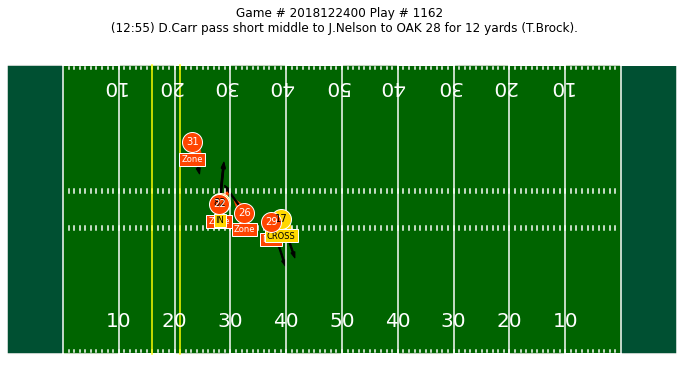

In [33]:
%%time
anim = animate_player_movement(weekData=weekFin, playId=pid, gameId=gid)
writer = FFMpegWriter(fps=10)
anim.save('anim.mp4', writer=writer)

In [35]:
Video('anim.mp4')

# WR and TE Routes vs Different Coverages

Something to focus on is on player routes and quantifying their effectiveness against man vs zone coverages. Using the framework from above, I have a method to determine whether the corner closest to a receiver is playing in man vs zone (i.e. it doesn't generalize for the entire defense, since there are some hybrid defenses and whatnot).

What we need to do:

- Identify whether a route runner is lined up against a defender with a classification for man vs zone
- If they are, then find their outcome for the play
     - If they were targeted, if caught, and if caught then how many yards?
- Also identify players who maximize yards against man, players who maximize yards against zone
    - A step further: which routes maximize yardage vs coverages? How to adjust for potential outliers / "explosive plays"?
    - One option is to consider yard line of receiver where the ball is caught, and consider that the metric to use

In [ ]:
weekFin['route'].unique()

In [ ]:
## Identify whether WR/TE is against a defender with man/zone
weekFin

## Get outcomes by play id
plays